Loading and cleaning data...
Data loaded successfully: 5802 records
Loading and cleaning data...
Data loaded successfully: 5802 records
Starting Netflix Stock Analysis...
Loading and cleaning data...
Data loaded successfully: 5802 records
Calculating technical indicators...

EXPLORATORY DATA ANALYSIS

Basic Statistics:
              open         high          low        close        volume
count  5802.000000  5802.000000  5802.000000  5802.000000  5.802000e+03
mean    172.720291   175.297992   170.150462   172.807773  1.515328e+07
std     234.674992   237.933952   231.550122   234.885388  1.837246e+07
min       0.377857     0.410714     0.346429     0.372857  2.856000e+05
25%       4.308928     4.401786     4.225714     4.307143  5.391400e+06
50%      47.290001    47.903570    46.326427    47.187143  9.374850e+06
75%     318.120003   323.845001   312.787491   317.935005  1.804652e+07
max    1259.410034  1262.810059  1237.290039  1250.520020  3.234140e+08

Key Metrics:
Total Return: 101

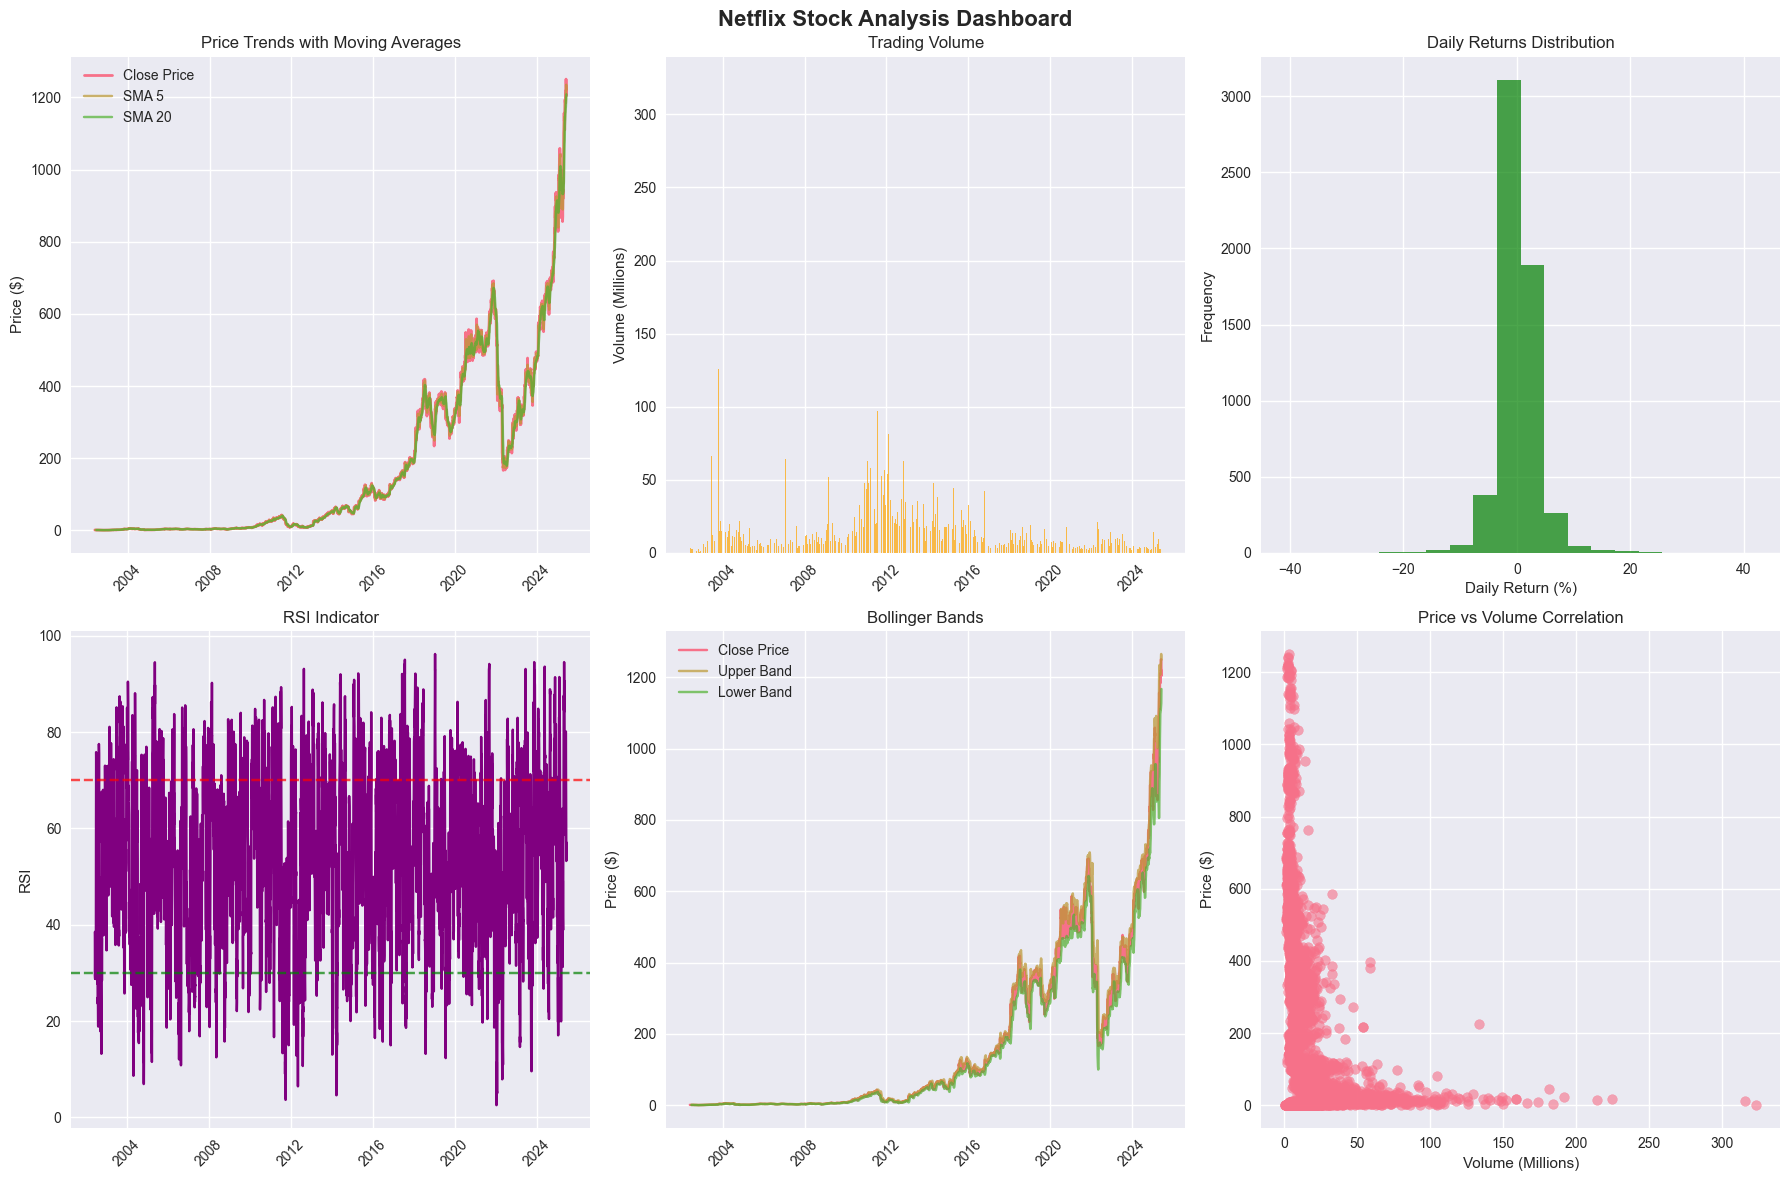

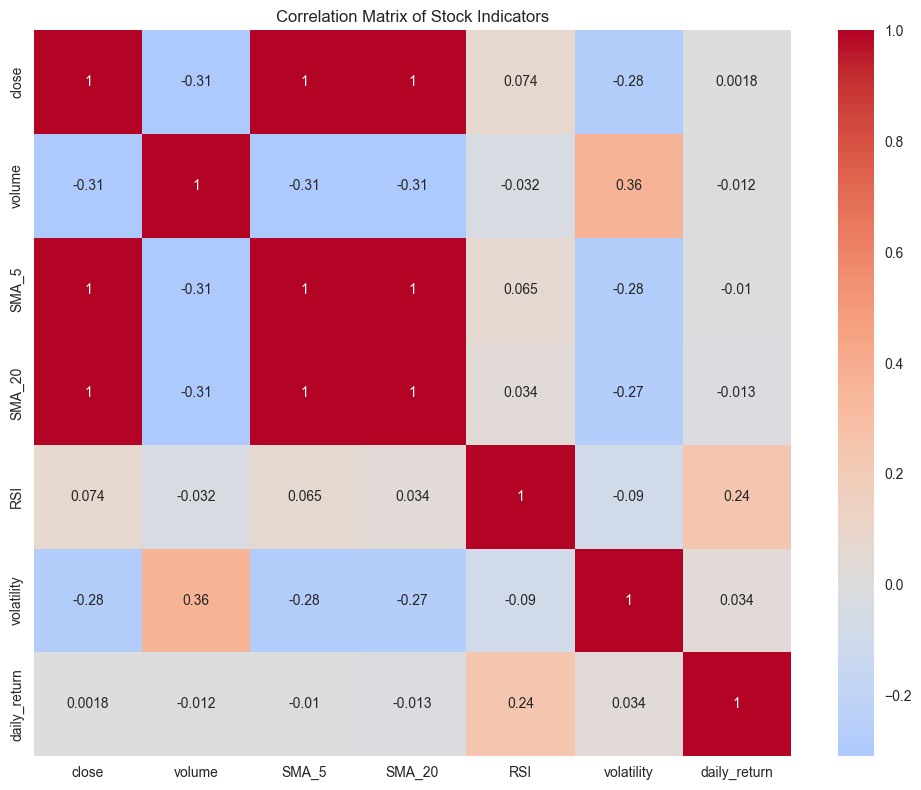


Preparing ML features...
Feature matrix shape: (5782, 22)
Target vector shape: (5782,)

Training machine learning models...

MODEL EVALUATION RESULTS

Linear Regression:
  RMSE: 12.4442
  MAE:  8.3269
  R²:   0.9963

Random Forest:
  RMSE: 205.6410
  MAE:  118.5997
  R²:   0.0020


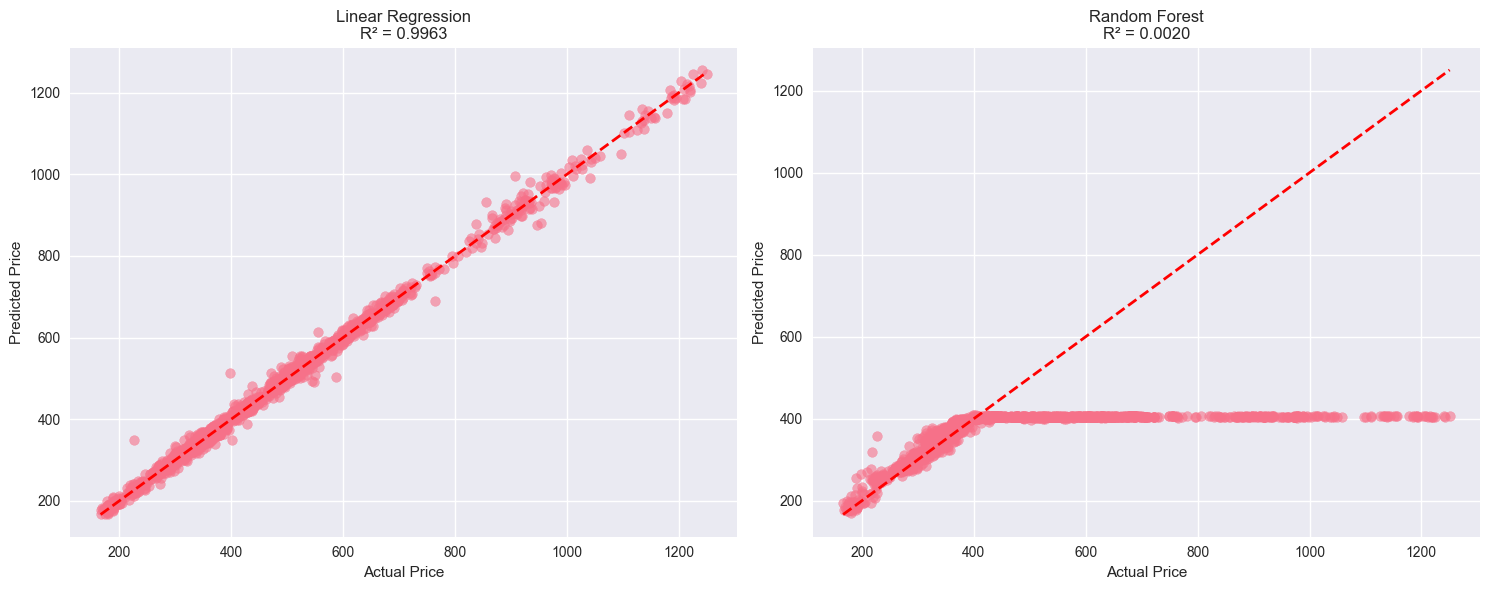

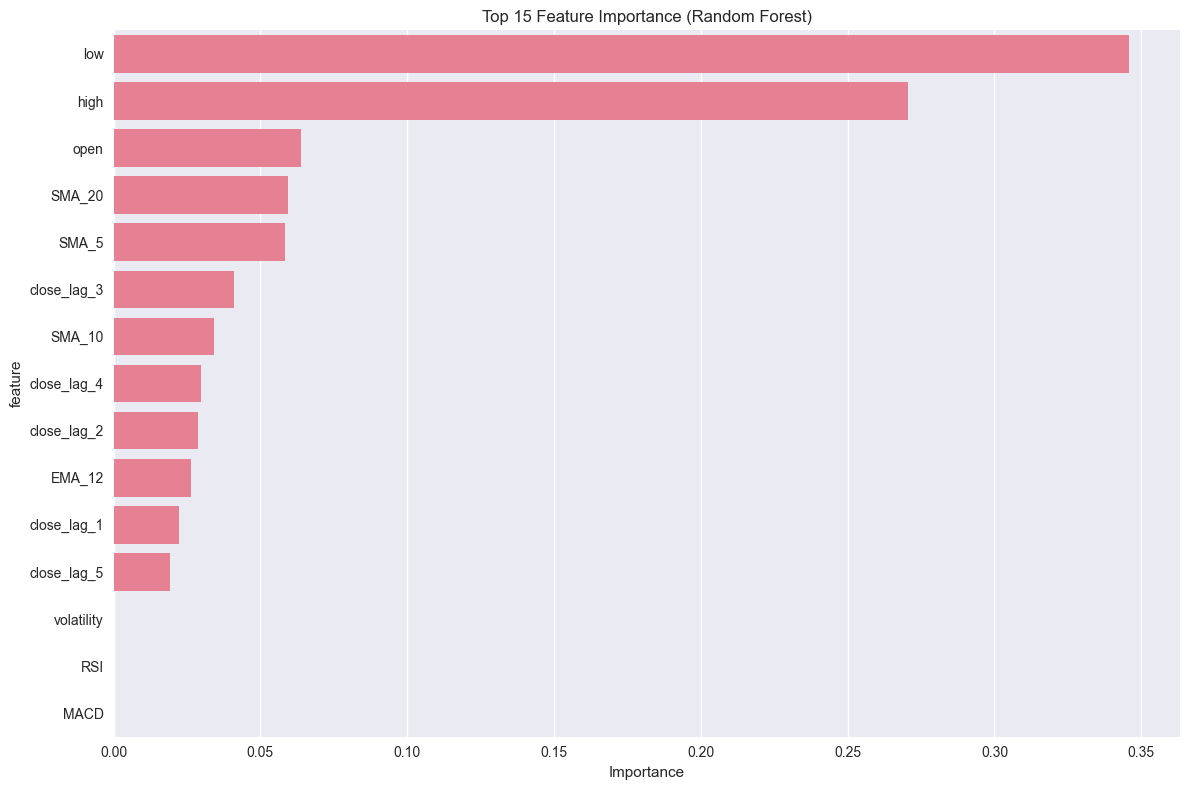


Top 10 Most Important Features:
  low: 0.3459
  high: 0.2705
  open: 0.0638
  SMA_20: 0.0594
  SMA_5: 0.0583
  close_lag_3: 0.0411
  SMA_10: 0.0341
  close_lag_4: 0.0298
  close_lag_2: 0.0289
  EMA_12: 0.0264

Predicting next 5 days...

Next Day Price Predictions:
  Linear Regression: $1220.74
  Random Forest: $405.81

TRADING SIGNALS
• RSI neutral at 56.5
• MA signals neutral
• Price within Bollinger bands - NORMAL

ANALYSIS COMPLETE!

Custom Analysis Examples:
------------------------------

Recent 5 days of data:
      date       close  volume       RSI       SMA_5      SMA_20
2025-06-05 1250.520020 2817200 74.754310 1226.865991 1187.227496
2025-06-06 1241.469971 2557000 67.582008 1233.713989 1192.079492
2025-06-09 1224.459961 2403100 60.325930 1234.809985 1196.291492
2025-06-10 1203.619995 4454400 53.233352 1231.945996 1200.972491
2025-06-11 1219.880005 2382300 56.540433 1227.989990 1205.044495

Risk Analysis:
Value at Risk (95%): -4.39%
Value at Risk (99%): -8.59%
Maximum Drawdow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class NetflixStockAnalyzer:
    def __init__(self, csv_file_path):
        """Initialize the analyzer with CSV file path"""
        self.csv_file_path = csv_file_path
        self.data = None
        self.features = None
        self.target = None
        self.models = {}
        self.predictions = {}
        
    def load_and_clean_data(self):
        """Load and clean the stock data"""
        print("Loading and cleaning data...")
        
        # Read CSV file
        self.data = pd.read_csv(self.csv_file_path)
        
        # Remove header row with 'NFLX' values and empty rows
        self.data = self.data[self.data['open'] != 'NFLX'].dropna()
        
        # Convert to numeric
        numeric_columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
        for col in numeric_columns:
            self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
        
        # Convert date
        self.data['date'] = pd.to_datetime(self.data['date'], format='%d/%m/%Y')
        
        # Remove any remaining NaN values
        self.data = self.data.dropna().reset_index(drop=True)
        
        print(f"Data loaded successfully: {len(self.data)} records")
        return self.data
    
    def calculate_technical_indicators(self):
        """Calculate technical indicators"""
        print("Calculating technical indicators...")
        
        # Simple Moving Averages
        self.data['SMA_5'] = self.data['close'].rolling(window=5).mean()
        self.data['SMA_10'] = self.data['close'].rolling(window=10).mean()
        self.data['SMA_20'] = self.data['close'].rolling(window=20).mean()
        
        # Exponential Moving Average
        self.data['EMA_12'] = self.data['close'].ewm(span=12).mean()
        
        # Price change and returns
        self.data['price_change'] = self.data['close'].diff()
        self.data['daily_return'] = self.data['close'].pct_change() * 100
        
        # Volatility (rolling standard deviation)
        self.data['volatility'] = self.data['daily_return'].rolling(window=10).std()
        
        # RSI calculation
        delta = self.data['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        self.data['RSI'] = 100 - (100 / (1 + rs))
        
        # MACD
        exp1 = self.data['close'].ewm(span=12).mean()
        exp2 = self.data['close'].ewm(span=26).mean()
        self.data['MACD'] = exp1 - exp2
        self.data['MACD_signal'] = self.data['MACD'].ewm(span=9).mean()
        
        # Bollinger Bands
        self.data['BB_middle'] = self.data['close'].rolling(window=20).mean()
        bb_std = self.data['close'].rolling(window=20).std()
        self.data['BB_upper'] = self.data['BB_middle'] + (bb_std * 2)
        self.data['BB_lower'] = self.data['BB_middle'] - (bb_std * 2)
        
        # Volume indicators
        self.data['volume_SMA'] = self.data['volume'].rolling(window=10).mean()
        self.data['volume_ratio'] = self.data['volume'] / self.data['volume_SMA']
        
    def exploratory_data_analysis(self):
        """Perform comprehensive EDA"""
        print("\n" + "="*50)
        print("EXPLORATORY DATA ANALYSIS")
        print("="*50)
        
        # Basic statistics
        print("\nBasic Statistics:")
        print(self.data[['open', 'high', 'low', 'close', 'volume']].describe())
        
        # Price statistics
        total_return = ((self.data['close'].iloc[-1] - self.data['close'].iloc[0]) / self.data['close'].iloc[0]) * 100
        max_price = self.data['high'].max()
        min_price = self.data['low'].min()
        avg_volume = self.data['volume'].mean()
        volatility = self.data['daily_return'].std()
        
        print(f"\nKey Metrics:")
        print(f"Total Return: {total_return:.2f}%")
        print(f"Maximum Price: ${max_price:.2f}")
        print(f"Minimum Price: ${min_price:.2f}")
        print(f"Average Volume: {avg_volume:,.0f}")
        print(f"Daily Volatility: {volatility:.2f}%")
        
        # Create comprehensive plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Netflix Stock Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # 1. Price trends with moving averages
        axes[0,0].plot(self.data['date'], self.data['close'], label='Close Price', linewidth=2)
        axes[0,0].plot(self.data['date'], self.data['SMA_5'], label='SMA 5', alpha=0.7)
        axes[0,0].plot(self.data['date'], self.data['SMA_20'], label='SMA 20', alpha=0.7)
        axes[0,0].set_title('Price Trends with Moving Averages')
        axes[0,0].set_ylabel('Price ($)')
        axes[0,0].legend()
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # 2. Volume analysis
        axes[0,1].bar(self.data['date'], self.data['volume']/1000000, alpha=0.7, color='orange')
        axes[0,1].set_title('Trading Volume')
        axes[0,1].set_ylabel('Volume (Millions)')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # 3. Daily returns distribution
        axes[0,2].hist(self.data['daily_return'].dropna(), bins=20, alpha=0.7, color='green')
        axes[0,2].set_title('Daily Returns Distribution')
        axes[0,2].set_xlabel('Daily Return (%)')
        axes[0,2].set_ylabel('Frequency')
        
        # 4. RSI indicator
        axes[1,0].plot(self.data['date'], self.data['RSI'], color='purple')
        axes[1,0].axhline(y=70, color='r', linestyle='--', alpha=0.7)
        axes[1,0].axhline(y=30, color='g', linestyle='--', alpha=0.7)
        axes[1,0].set_title('RSI Indicator')
        axes[1,0].set_ylabel('RSI')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # 5. Bollinger Bands
        axes[1,1].plot(self.data['date'], self.data['close'], label='Close Price')
        axes[1,1].plot(self.data['date'], self.data['BB_upper'], label='Upper Band', alpha=0.7)
        axes[1,1].plot(self.data['date'], self.data['BB_lower'], label='Lower Band', alpha=0.7)
        axes[1,1].fill_between(self.data['date'], self.data['BB_upper'], self.data['BB_lower'], alpha=0.2)
        axes[1,1].set_title('Bollinger Bands')
        axes[1,1].set_ylabel('Price ($)')
        axes[1,1].legend()
        axes[1,1].tick_params(axis='x', rotation=45)
        
        # 6. Price vs Volume correlation
        axes[1,2].scatter(self.data['volume']/1000000, self.data['close'], alpha=0.6)
        axes[1,2].set_title('Price vs Volume Correlation')
        axes[1,2].set_xlabel('Volume (Millions)')
        axes[1,2].set_ylabel('Price ($)')
        
        plt.tight_layout()
        plt.show()
        
        # Correlation heatmap
        corr_cols = ['close', 'volume', 'SMA_5', 'SMA_20', 'RSI', 'volatility', 'daily_return']
        correlation_matrix = self.data[corr_cols].corr()
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix of Stock Indicators')
        plt.tight_layout()
        plt.show()
    
    def prepare_ml_features(self):
        """Prepare features for machine learning"""
        print("\nPreparing ML features...")
        
        # Create lagged features
        for lag in range(1, 6):
            self.data[f'close_lag_{lag}'] = self.data['close'].shift(lag)
            self.data[f'volume_lag_{lag}'] = self.data['volume'].shift(lag)
        
        # Create target variable (next day's close price)
        self.data['target'] = self.data['close'].shift(-1)
        
        # Select features
        feature_columns = [
            'open', 'high', 'low', 'volume', 'SMA_5', 'SMA_10', 'SMA_20',
            'EMA_12', 'RSI', 'MACD', 'volatility', 'volume_ratio'
        ]
        
        # Add lagged features
        feature_columns.extend([f'close_lag_{i}' for i in range(1, 6)])
        feature_columns.extend([f'volume_lag_{i}' for i in range(1, 6)])
        
        # Remove rows with NaN values
        self.data = self.data.dropna()
        
        self.features = self.data[feature_columns]
        self.target = self.data['target']
        
        print(f"Feature matrix shape: {self.features.shape}")
        print(f"Target vector shape: {self.target.shape}")
    
    def train_ml_models(self):
        """Train multiple ML models"""
        print("\nTraining machine learning models...")
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            self.features, self.target, test_size=0.3, random_state=42, shuffle=False
        )
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Store scaler for later use
        self.scaler = scaler
        
        # 1. Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train_scaled, y_train)
        lr_pred = lr_model.predict(X_test_scaled)
        
        # 2. Random Forest
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        
        # Store models and predictions
        self.models = {
            'Linear Regression': lr_model,
            'Random Forest': rf_model
        }
        
        self.predictions = {
            'Linear Regression': lr_pred,
            'Random Forest': rf_pred
        }
        
        # Store test data for evaluation
        self.X_test = X_test
        self.y_test = y_test
        self.X_test_scaled = X_test_scaled
        
        # Evaluate models
        self.evaluate_models()
    
    def evaluate_models(self):
        """Evaluate ML model performance"""
        print("\n" + "="*50)
        print("MODEL EVALUATION RESULTS")
        print("="*50)
        
        results = {}
        
        for model_name, predictions in self.predictions.items():
            mse = mean_squared_error(self.y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(self.y_test, predictions)
            r2 = r2_score(self.y_test, predictions)
            
            results[model_name] = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2
            }
            
            print(f"\n{model_name}:")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE:  {mae:.4f}")
            print(f"  R²:   {r2:.4f}")
        
        # Plot predictions vs actual
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        for i, (model_name, predictions) in enumerate(self.predictions.items()):
            axes[i].scatter(self.y_test, predictions, alpha=0.6)
            axes[i].plot([self.y_test.min(), self.y_test.max()], 
                        [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
            axes[i].set_xlabel('Actual Price')
            axes[i].set_ylabel('Predicted Price')
            axes[i].set_title(f'{model_name}\nR² = {results[model_name]["R²"]:.4f}')
        
        plt.tight_layout()
        plt.show()
        
        # Feature importance for Random Forest
        if 'Random Forest' in self.models:
            feature_importance = pd.DataFrame({
                'feature': self.features.columns,
                'importance': self.models['Random Forest'].feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(12, 8))
            sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
            plt.title('Top 15 Feature Importance (Random Forest)')
            plt.xlabel('Importance')
            plt.tight_layout()
            plt.show()
            
            print("\nTop 10 Most Important Features:")
            for i, row in feature_importance.head(10).iterrows():
                print(f"  {row['feature']}: {row['importance']:.4f}")
    
    def predict_next_prices(self, days=5):
        """Predict next few days' prices"""
        print(f"\nPredicting next {days} days...")
        
        # Use the last row of features for prediction
        last_features = self.features.iloc[-1:].values
        last_features_scaled = self.scaler.transform(last_features)
        
        predictions = {}
        for model_name, model in self.models.items():
            if model_name == 'Linear Regression':
                pred = model.predict(last_features_scaled)[0]
            else:
                pred = model.predict(last_features)[0]
            predictions[model_name] = pred
        
        print("\nNext Day Price Predictions:")
        for model_name, pred in predictions.items():
            print(f"  {model_name}: ${pred:.2f}")
        
        return predictions
    
    def generate_trading_signals(self):
        """Generate simple trading signals"""
        print("\n" + "="*50)
        print("TRADING SIGNALS")
        print("="*50)
        
        signals = []
        
        # RSI signals
        current_rsi = self.data['RSI'].iloc[-1]
        if current_rsi > 70:
            signals.append("RSI indicates OVERBOUGHT - Consider SELL")
        elif current_rsi < 30:
            signals.append("RSI indicates OVERSOLD - Consider BUY")
        else:
            signals.append(f"RSI neutral at {current_rsi:.1f}")
        
        # Moving average crossover
        current_price = self.data['close'].iloc[-1]
        sma_5 = self.data['SMA_5'].iloc[-1]
        sma_20 = self.data['SMA_20'].iloc[-1]
        
        if sma_5 > sma_20 and current_price > sma_5:
            signals.append("MA crossover indicates BULLISH - Consider BUY")
        elif sma_5 < sma_20 and current_price < sma_5:
            signals.append("MA crossover indicates BEARISH - Consider SELL")
        else:
            signals.append("MA signals neutral")
        
        # Bollinger Bands
        bb_upper = self.data['BB_upper'].iloc[-1]
        bb_lower = self.data['BB_lower'].iloc[-1]
        
        if current_price > bb_upper:
            signals.append("Price above Bollinger upper band - OVERBOUGHT")
        elif current_price < bb_lower:
            signals.append("Price below Bollinger lower band - OVERSOLD")
        else:
            signals.append("Price within Bollinger bands - NORMAL")
        
        for signal in signals:
            print(f"• {signal}")
    
    def run_complete_analysis(self):
        """Run the complete analysis pipeline"""
        print("Starting Netflix Stock Analysis...")
        print("="*50)
        
        # Load and prepare data
        self.load_and_clean_data()
        self.calculate_technical_indicators()
        
        # Perform EDA
        self.exploratory_data_analysis()
        
        # Machine Learning
        self.prepare_ml_features()
        self.train_ml_models()
        
        # Predictions and signals
        self.predict_next_prices()
        self.generate_trading_signals()
        
        print("\n" + "="*50)
        print("ANALYSIS COMPLETE!")
        print("="*50)

# Usage example
if __name__ == "__main__":
    # Initialize analyzer
    # Create analyzer instance with your CSV file
    analyzer = NetflixStockAnalyzer("/Users/44790/Documents/projects/NFLX_stocks.csv")

# Load the data
analyzer.load_and_clean_data()# Create analyzer instance with your CSV file
analyzer = NetflixStockAnalyzer("/Users/44790/Documents/projects/NFLX_stocks.csv")

# Load the data
analyzer.load_and_clean_data()  # Replace with your CSV file path
    
    # Run complete analysis
analyzer.run_complete_analysis()
    
    # Additional analysis examples:
    
    # Custom predictions
print("\nCustom Analysis Examples:")
print("-" * 30)
    
    # Show recent data
print("\nRecent 5 days of data:")
recent_data = analyzer.data[['date', 'close', 'volume', 'RSI', 'SMA_5', 'SMA_20']].tail()
print(recent_data.to_string(index=False))
    
    # Risk analysis
print(f"\nRisk Analysis:")
returns = analyzer.data['daily_return'].dropna()
var_95 = np.percentile(returns, 5)
var_99 = np.percentile(returns, 1)
print(f"Value at Risk (95%): {var_95:.2f}%")
print(f"Value at Risk (99%): {var_99:.2f}%")
print(f"Maximum Drawdown: {returns.min():.2f}%")
    
print("\nAnalysis saved! Check the generated plots for visual insights.")